In [2]:
import re
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
#corpus

from glob import glob
docs = []
file_names = []
for file_name in glob("input_multiple/*.txt"):
 with open(file_name, "rt") as ifd:
    tokens = ifd.read().strip().split()
    docs.append(tokens)
    file_names.append(file_name)
 print(docs)

[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab']]
[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab']]
[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['to', 'the', 'goddess', 'Inanna', 'Aka', 'king', 'of', 'Umma']]
[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['to', 'the', 'goddess', 'Inanna', 'Aka', 'king', 'of', 'Umma'], ['Esar', 'Barahenidu']]
[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['to', 'the', 'goddess', 'Inanna', 'Aka', 'king', 'of', 'Umma'], ['Esar', 'Barahenidu'], ['the', 'Esar', 'Lugaldalu', 'king', 'of', 'Adab']]
[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['to', 'the', 'goddess', 'Inanna', 'Aka', 'king', 'of', 'Umma'], ['Esar'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
# NLTK Stop words
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 're', 'edu', 'use', '-pron-',])
#'ningirsu', 'lugal', 'habura', 'lumma', 'dabrum', 'shulmushpa', 'inshushinak', 'lagash', 'ninsuna', 'eshnunna', 'zabshali', 'dumuzi', 'aanepada', 'simurrum', 'tirigan', 'enakale', 'urbillum', 'geshtinanna', 'ephur', 'shin', 'sippar', 'ephur', 'magur', 'shatillu', 'garta', 'alumidatum', 'nushushmar', 'alum', 'gisha', 'ninmarki', 'hendursag', 'guedena', 'hegal', 'erridupizir', 'ninshubur', 'ninhursaga', 'enlil', 'sargon', 'lugalmarda', 'shin', 'kazallu', 'push', 'bashar', 'shishil', 'dada', 'nisaba', 'dudu', 'eanatum', 'enmetena', 'ningal', 'dagan', 'urlumma', 'eridu', 'ibbisin', 'tiwa', 'nagarbi', 'abgal', 'zubi', 'meenlil', 'usarum', 'ilaba', 'annunitum', 'apiak', 'anshan', 'subartum', 'kigal', 'eresh', 'apiak', 'meenili', 'utu', 'magan', 'lugalkiginedudu', 'sharkalisharri', 'shin', 'gunidu', 'bagara', 'tirash', 'ningirsus', 'ebla', 'utu_hegal', 'utuhegal', 'ishkur', 'enanatum', 'baba', 'antasur', 'uruxkar', 'rec', 'gatumdu', 'nergal', 'simashki', 'lugal_uruxkar', 'enki', 'shara', 'uruk', 'nippur', 'mari', 'urukagina', 'numushda', 'inanna', 'naram', 'ishtar', 'kurgal', 'ninlil', 'whose', 'shusin', 'umma', 'nanshe', 'amarsin', 'rimush', 'naram_sin', 'girsu', 'shulgi', 'nammu', 'elam', 'agade', 'parahshum', 'shamash', 'susa', 'kish', 'simanum', 'kutha', 'gunida', 'gursar', 'nanna', 'adab', 'ningursaga', 'gutium', 'sheshgar', 'irnina', 'hibaritum', 'ishtar_annunitum', 'ninhursag', 'sin', 'abzu', 'epa', 'ibgal', 'edam', 'dilmun', 'kinir', 'emah', 'ningar', 'giguna', 'eamma', 'eras', 'manishtushu', 'urtur', 'kindazi', 'emeslam', 'emunusgisa', 'ninkununa', 'gipar', 'karzida', 'pasira', 'etemeniguru', 'geshtinana', 'armanum', 'euphrates', 'esar', 'amanus', 'enlil', 'puzur', 'eninsar', 'nissaba', 'rigmushdan', 'etunigaana', 'eduruenki', 'hiritum', 'lagardingirigi', 'kirilum', 'ekur', 'eninnu',' eada', 'eengur', 'imsag', 'zulum', 'igalim', 'eshdugru', 'ahush', 'ninsar', 'shin', 'lugalemush', 'urningirsu', 'enmezianna', 'kian', 'adad', 'eras'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 

In [5]:
# Convert to list
data = list(docs)
print(data)

[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['to', 'the', 'goddess', 'Inanna', 'Aka', 'king', 'of', 'Umma'], ['Esar', 'Barahenidu'], ['the', 'Esar', 'Lugaldalu', 'king', 'of', 'Adab'], ['the', 'Esar', 'Lumma'], ['Lumma', 'the', 'ensigar'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensi', 'of', 'Adab', 'who', 'built', 'the', 'Emah'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensigar', 'of', 'Adab', 'built', 'the', 'Emah', 'for', 'her', 'buried', 'foundation', 'deposits', 'below', 'its', 'base'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensigar', 'of', 'Adab', 'built', 'the', 'Emah', 'for', 'her', 'buried', 'foundation', 'deposits', 'below', 'its', 'base'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensigar', 'of', 'Adab', 'built', 'the', 'Emah', 'for', 'her', 'buried', 'foundation', 'deposits', 'below', 'its', 'base'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'en

In [6]:
#Tokenize and Clean-up

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'esar', 'mebalak', 'king', 'of', 'adab']]


In [7]:
#lemmatize

from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(data_words)

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/meganlewis/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['the', 'esar', 'mebalak', 'king', 'of', 'adab']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['esar', 'mebalak', 'king', 'adab']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adab', 1), ('esar', 1), ('king', 1), ('mebalak', 1)]]

In [13]:
# step 12

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=26, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=500,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# step 13

# Print the Keyword in the topics
pprint(lda_model.print_topics(num_topics=26))
doc_lda = lda_model[corpus]

[(0,
  '0.249*"battle" + 0.128*"foundation" + 0.062*"girsu" + 0.058*"priest" + '
  '0.035*"simashki" + 0.025*"gate" + 0.022*"bronze_argibillu" + '
  '0.019*"ninmarki" + 0.013*"nissaba" + 0.013*"me"'),
 (1,
  '0.073*"land" + 0.057*"ibbisin" + 0.055*"field" + 0.043*"set" + '
  '0.026*"decision" + 0.025*"whose_loophole" + 0.025*"therefore" + '
  '0.025*"footing" + 0.025*"found_place" + 0.025*"surround"'),
 (2,
  '0.154*"enki" + 0.125*"abzu" + 0.045*"shrine" + 0.045*"go" + 0.042*"side" + '
  '0.037*"form" + 0.033*"nindan" + 0.025*"make" + 0.018*"military_governor" + '
  '0.018*"perpetuity"'),
 (3,
  '0.339*"goddess" + 0.263*"lady" + 0.177*"urnammu" + 0.033*"karzida" + '
  '0.033*"ningal" + 0.017*"giparu" + 0.012*"offspring" + 0.009*"ninhursag" + '
  '0.006*"ninsuna" + 0.006*"shining_gipar"'),
 (4,
  '0.137*"establish" + 0.056*"rebel" + 0.034*"held_back" + 0.029*"fashioned" + '
  '0.025*"weight" + 0.025*"standardize" + 0.025*"settle" + 0.024*"scepter" + '
  '0.017*"royal" + 0.017*"justice"'

In [15]:
#percentage of topic in document
doc_lda = lda_model[corpus]
for i, row in enumerate(doc_lda):
    print(file_names[i], row[0])

input_multiple/E1.1.2.1 copy.txt [(3, 0.04020401), (6, 0.0118207475), (7, 0.09990364), (8, 0.021580638), (9, 0.07703975), (11, 0.023030702), (13, 0.25026217), (15, 0.07681362), (17, 0.052395288), (18, 0.016746344), (19, 0.015390778), (20, 0.029194126), (21, 0.16013904), (23, 0.017735736), (24, 0.028604968), (25, 0.027457943)]
input_multiple/E1.1.2.1.txt [(3, 0.04020401), (6, 0.0118207475), (7, 0.09990364), (8, 0.021580638), (9, 0.07703975), (11, 0.023030702), (13, 0.25026217), (15, 0.07681362), (17, 0.052395288), (18, 0.016746344), (19, 0.015390778), (20, 0.029194126), (21, 0.16013904), (23, 0.017735736), (24, 0.028604968), (25, 0.027457943)]
input_multiple/E1.1.2.2.txt [(3, 0.095377095), (6, 0.010969578), (7, 0.020703558), (8, 0.020026695), (9, 0.0714924), (11, 0.09337872), (13, 0.30424806), (15, 0.07128255), (17, 0.048622493), (18, 0.10095597), (19, 0.014282544), (20, 0.027091963), (23, 0.01645865), (24, 0.027074497), (25, 0.025480796)]
input_multiple/E1.1.3.1.txt [(0, 0.010188468), 

input_multiple/E1.9.5.10.txt [(2, 0.053952627), (3, 0.024805821), (7, 0.013765254), (8, 0.013315225), (9, 0.07019053), (11, 0.014209913), (13, 0.10653628), (15, 0.09707531), (17, 0.032327823), (18, 0.4641233), (20, 0.018012738), (23, 0.010942926), (24, 0.018146701), (25, 0.016941514)]
input_multiple/E1.9.5.11.txt [(2, 0.027561968), (3, 0.013562492), (9, 0.07920669), (13, 0.05442458), (15, 0.06375384), (17, 0.016514828), (18, 0.5301301), (19, 0.029308386), (20, 0.033659156), (23, 0.03004751), (24, 0.07358039)]
input_multiple/E1.9.5.12.txt [(2, 0.024186874), (9, 0.054446083), (13, 0.048076075), (15, 0.25337005), (17, 0.019061282), (18, 0.39660704), (19, 0.013635033), (20, 0.1180626), (21, 0.012104289), (23, 0.013978893), (24, 0.0172638)]
input_multiple/E1.9.5.13.txt [(3, 0.019270385), (7, 0.010693528), (8, 0.010343923), (9, 0.11190713), (11, 0.011038961), (13, 0.08276263), (15, 0.10211866), (17, 0.025113847), (18, 0.53686935), (20, 0.013993182), (24, 0.014038766), (25, 0.013161004)]
inpu

input_multiple/E2.1.4.30.txt [(0, 0.025313003), (2, 0.055885352), (3, 0.011805952), (7, 0.074907705), (9, 0.022622805), (13, 0.11906065), (15, 0.022556404), (16, 0.04662832), (17, 0.060956802), (20, 0.28199825), (22, 0.18338345), (24, 0.04654855)]
input_multiple/E2.1.4.31.txt [(0, 0.050755937), (2, 0.05148765), (3, 0.023672497), (5, 0.14197534), (7, 0.15019989), (8, 0.013359897), (9, 0.090277106), (11, 0.013560693), (13, 0.19239154), (15, 0.04522858), (16, 0.04780812), (17, 0.030850835), (20, 0.017189775), (22, 0.047893215), (23, 0.010442967), (24, 0.01753369), (25, 0.016167494)]
input_multiple/E2.1.4.32.txt [(2, 0.010678656), (3, 0.04358601), (5, 0.09316451), (6, 0.012815119), (7, 0.10830762), (8, 0.02339602), (9, 0.0835204), (10, 0.08685237), (11, 0.024968065), (13, 0.18719359), (15, 0.08327525), (17, 0.056802824), (18, 0.01815506), (19, 0.016685463), (20, 0.031649962), (23, 0.019227682), (24, 0.03101124), (25, 0.029767727)]
input_multiple/E2.1.4.35.txt [(3, 0.032612454), (7, 0.08103

input_multiple/E3:2.1.1.11 copy 81.txt [(3, 0.024805821), (7, 0.013765254), (8, 0.06119038), (9, 0.28670278), (11, 0.014209913), (13, 0.2980369), (15, 0.14313333), (17, 0.032327823), (18, 0.010366564), (20, 0.018012738), (23, 0.010942926), (24, 0.017832486), (25, 0.016941514)]
input_multiple/E3:2.1.1.11 copy 82.txt [(3, 0.024805823), (7, 0.013765255), (8, 0.06119039), (9, 0.2867027), (11, 0.014209914), (13, 0.29803693), (15, 0.14313333), (17, 0.032327827), (18, 0.010366583), (20, 0.01801274), (23, 0.010942927), (24, 0.01783258), (25, 0.016941516)]
input_multiple/E3:2.1.1.11 copy 83.txt [(3, 0.024805821), (7, 0.013765254), (8, 0.06119038), (9, 0.28670257), (11, 0.014209913), (13, 0.2980369), (15, 0.14313333), (17, 0.032327823), (18, 0.010366574), (20, 0.018012738), (23, 0.010942926), (24, 0.017832652), (25, 0.016941514)]
input_multiple/E3:2.1.1.11 copy 84.txt [(3, 0.024805821), (7, 0.013765254), (8, 0.06119038), (9, 0.28670266), (11, 0.014209913), (13, 0.2980369), (15, 0.14313331), (17,

input_multiple/E3:2.1.1.27.txt [(3, 0.13587679), (5, 0.04278131), (6, 0.12177007), (7, 0.011106603), (8, 0.010743494), (9, 0.038352713), (11, 0.050093826), (13, 0.2404734), (15, 0.038240142), (17, 0.14196928), (20, 0.053162165), (24, 0.014240417), (25, 0.052297838)]
input_multiple/E3:2.1.1.28 copy 2.txt [(6, 0.05541346), (7, 0.11052527), (8, 0.07841145), (9, 0.09099257), (12, 0.104877345), (13, 0.14458838), (15, 0.070134275), (17, 0.06460544), (20, 0.05934932), (24, 0.17702304)]
input_multiple/E3:2.1.1.28 copy 3.txt [(6, 0.055413455), (7, 0.110525265), (8, 0.07840876), (9, 0.09097528), (12, 0.104876444), (13, 0.14458837), (15, 0.07013427), (17, 0.06460544), (20, 0.05934932), (24, 0.17704383)]
input_multiple/E3:2.1.1.28 copy 4.txt [(6, 0.055413455), (7, 0.110525265), (8, 0.078407116), (9, 0.0909731), (12, 0.104875945), (13, 0.14458837), (15, 0.07013444), (17, 0.06460544), (20, 0.05934932), (24, 0.17704912)]
input_multiple/E3:2.1.1.28 copy 5.txt [(6, 0.055413455), (7, 0.110525265), (8, 0

input_multiple/E3:2.1.2.16 copy 8.txt [(3, 0.109979756), (7, 0.012562401), (8, 0.012151698), (9, 0.0433798), (11, 0.012968205), (13, 0.27199346), (15, 0.08694415), (17, 0.16057788), (20, 0.016438726), (21, 0.046479966), (23, 0.09737003), (24, 0.01610698), (25, 0.059152782)]
input_multiple/E3:2.1.2.16 copy.txt [(3, 0.10997604), (7, 0.0125624), (8, 0.012151697), (9, 0.043379795), (11, 0.012968203), (13, 0.27199343), (15, 0.08694414), (17, 0.1605779), (20, 0.016438724), (21, 0.046479963), (23, 0.097370036), (24, 0.016106978), (25, 0.05915278)]
input_multiple/E3:2.1.2.16.txt [(3, 0.10997454), (7, 0.0125624), (8, 0.012151697), (9, 0.043379795), (11, 0.012968203), (13, 0.27199343), (15, 0.08694414), (17, 0.1605779), (20, 0.016438724), (21, 0.046479963), (23, 0.097370036), (24, 0.016106978), (25, 0.05915278)]
input_multiple/E3:2.1.2.17.txt [(3, 0.10998509), (7, 0.0125624), (8, 0.012151697), (9, 0.043379795), (10, 0.04336609), (11, 0.012968203), (13, 0.27199343), (15, 0.13063581), (17, 0.16057

input_multiple/E3:2.1.3.1 copy 60.txt [(3, 0.022638205), (7, 0.0125624), (8, 0.012151697), (9, 0.30519846), (11, 0.05665987), (13, 0.31568515), (15, 0.08694413), (17, 0.02950291), (20, 0.060130388), (24, 0.016401969), (25, 0.015461109)]
input_multiple/E3:2.1.3.1 copy 61.txt [(3, 0.022638205), (7, 0.0125624), (8, 0.012151697), (9, 0.30519965), (11, 0.05665987), (13, 0.31568512), (15, 0.08694414), (17, 0.02950291), (20, 0.060130395), (24, 0.016400412), (25, 0.015461109)]
input_multiple/E3:2.1.3.1 copy 62.txt [(3, 0.022638205), (7, 0.0125624), (8, 0.012151697), (9, 0.30519888), (11, 0.05665987), (13, 0.31568512), (15, 0.08694414), (17, 0.02950291), (20, 0.060130388), (24, 0.01640158), (25, 0.015461109)]
input_multiple/E3:2.1.3.1 copy 63.txt [(3, 0.022638205), (7, 0.0125624), (8, 0.012151697), (9, 0.30519846), (11, 0.05665987), (13, 0.31568515), (15, 0.08694414), (17, 0.02950291), (20, 0.060130395), (24, 0.016401736), (25, 0.015461109)]
input_multiple/E3:2.1.3.1 copy 64.txt [(3, 0.02263820

input_multiple/E3:2.1.4.10 copy 15.txt [(3, 0.02896609), (7, 0.016073871), (8, 0.015548367), (9, 0.16676104), (11, 0.016593106), (13, 0.40392613), (14, 0.057199802), (15, 0.0553425), (17, 0.037749633), (18, 0.012322759), (19, 0.011088711), (20, 0.021033715), (23, 0.012778201), (24, 0.021095779), (25, 0.0756873)]
input_multiple/E3:2.1.4.10 copy 2.txt [(3, 0.02896609), (7, 0.016073871), (8, 0.015548367), (9, 0.16675672), (11, 0.016593106), (13, 0.40392613), (14, 0.057187866), (15, 0.0553425), (17, 0.037749633), (18, 0.012338673), (19, 0.011088711), (20, 0.021033715), (23, 0.012778201), (24, 0.021096133), (25, 0.0756873)]
input_multiple/E3:2.1.4.10 copy 3.txt [(3, 0.02896609), (7, 0.016073871), (8, 0.015548367), (9, 0.16675799), (11, 0.016593106), (13, 0.40392613), (14, 0.057190973), (15, 0.0553425), (17, 0.037749633), (18, 0.012334535), (19, 0.011088711), (20, 0.021033715), (23, 0.012778201), (24, 0.021095905), (25, 0.0756873)]
input_multiple/E3:2.1.4.10 copy 4.txt [(3, 0.02896609), (7, 

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.505033183913222

Coherence Score:  0.4402826623568916


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/meganlewis/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.152477 -0.269986       1        1  16.934591
9      0.321328  0.129344       2        1   9.159064
20    -0.049693 -0.001143       3        1   8.356611
15     0.124009 -0.122191       4        1   7.486769
7     -0.058968  0.014552       5        1   7.220243
24     0.243157  0.156886       6        1   6.741621
18     0.276538  0.143169       7        1   6.356284
17     0.062942 -0.283774       8        1   5.773994
3      0.109985  0.020644       9        1   3.853547
19    -0.023203 -0.042262      10        1   2.803359
25    -0.006659 -0.047431      11        1   2.785407
11    -0.026518 -0.036735      12        1   2.479650
8     -0.007024  0.012566      13        1   2.097010
6     -0.040513 -0.012256      14        1   1.984449
1     -0.034334 -0.166271      15        1   1.979464
14     0.002964  0.026279      16        1   1.974903
21    -0.087031  0.031205      17        1   1.777211
5     -0.087105  0.054415      18        1   1.741704
23    -0.066197  0.011566      19        1   1.629409
2     -0.078446  0.049402      20        1   1.598456
4     -0.095192  0.034701      21        1   1.417085
0     -0.086566  0.023829      22        1   1.373559
16    -0.121588  0.054594      23        1   0.793264
22    -0.140915  0.067280      24        1   0.651410
10    -0.132809  0.076611      25        1   0.562945
12    -0.150640  0.075009      26        1   0.467988, topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
2     Default  2630.000000             king  2630.000000  30.0000  30.0000
12    Default  1196.000000            build  1196.000000  29.0000  29.0000
63    Default  1148.000000            enlil  1148.000000  28.0000  28.0000
22    Default  1522.000000              god  1522.000000  27.0000  27.0000
42    Default   815.000000             land   815.000000  26.0000  26.0000
95    Default   785.000000           temple   785.000000  25.0000  25.0000
106   Default   523.000000          beloved   523.000000  24.0000  24.0000
141   Default  1027.000000           mighty  1027.000000  23.0000  23.0000
5     Default   621.000000          goddess   621.000000  22.0000  22.0000
215   Default   422.000000            nanna   422.000000  21.0000  21.0000
164   Default   474.000000            sumer   474.000000  20.0000  20.0000
316   Default   763.000000              man   763.000000  19.0000  19.0000
1687  Default   448.000000            akkad   448.000000  18.0000  18.0000
108   Default   321.000000            canal   321.000000  17.0000  17.0000
28    Default   338.000000             name   338.000000  16.0000  16.0000
200   Default   351.000000             lady   351.000000  15.0000  15.0000
1861  Default   251.000000           shulgi   251.000000  14.0000  14.0000
186   Default   596.000000             lord   596.000000  13.0000  13.0000
140   Default   349.000000              may   349.000000  12.0000  12.0000
59    Default   350.000000              son   350.000000  11.0000  11.0000
1336  Default   466.000000          quarter   466.000000  10.0000  10.0000
1572  Default   236.000000          urnammu   236.000000   9.0000   9.0000
6     Default   174.000000           inanna   174.000000   8.0000   8.0000
332   Default   236.000000         ningirsu   236.000000   7.0000   7.0000
1969  Default   267.000000          amarsin   267.000000   6.0000   6.0000
783   Default   251.000000             call   251.000000   5.0000   5.0000
2041  Default   189.000000           shusin   189.000000   4.0000   4.0000
205   Default   154.000000            great   154.000000   3.0000   3.0000
367   Default   119.000000           battle   119.000000   2.0000   2.0000
113   Default   126.000000          destroy   126.000000   1.0000   1.0000
...       ...          ...              ...  

for doc in corpus:
   print(lda_model.get_document_topics(doc))

In [18]:
for text, doc in zip(texts, corpus):
   print("{}\n{}\n\n".format(text, lda_model.get_document_topics(doc)))

['esar', 'mebalak', 'king', 'adab']
[(3, 0.04020401), (6, 0.0118207475), (7, 0.09990364), (8, 0.021580638), (9, 0.07703975), (11, 0.023030702), (13, 0.25026217), (15, 0.07681362), (17, 0.052395288), (18, 0.016746344), (19, 0.015390778), (20, 0.029194126), (21, 0.16013904), (23, 0.017735736), (24, 0.028604968), (25, 0.027457943)]


['esar', 'mebalak', 'king', 'adab']
[(3, 0.04020401), (6, 0.0118207475), (7, 0.09990364), (8, 0.021580638), (9, 0.07703975), (11, 0.023030702), (13, 0.25026217), (15, 0.07681362), (17, 0.052395288), (18, 0.016746344), (19, 0.015390778), (20, 0.029194126), (21, 0.16013904), (23, 0.017735736), (24, 0.028604968), (25, 0.027457943)]


['goddess', 'inanna', 'aka', 'king', 'umma']
[(3, 0.095245354), (6, 0.010969578), (7, 0.020703558), (8, 0.020026695), (9, 0.0714924), (11, 0.09337872), (13, 0.30424806), (15, 0.07128255), (17, 0.048622493), (18, 0.10106755), (19, 0.014282544), (20, 0.027091963), (23, 0.01645865), (24, 0.027094644), (25, 0.025480796)]


['esar', 'bar

['goddess', 'inanna', 'lady', 'mighty', 'man', 'king', 'king', 'land', 'sumer', 'akkad', 'build', 'temple']
[(3, 0.120508544), (7, 0.013765254), (8, 0.013315225), (9, 0.047533423), (11, 0.062085073), (13, 0.2980369), (15, 0.14314422), (17, 0.17595327), (18, 0.010380065), (20, 0.018012738), (23, 0.010942926), (24, 0.017649226), (25, 0.016941514)]


['goddess', 'inanna', 'lady', 'mighty', 'man', 'king', 'king', 'land', 'sumer', 'akkad', 'build', 'temple']
[(3, 0.12050799), (7, 0.013765254), (8, 0.013315225), (9, 0.047533423), (11, 0.062085073), (13, 0.2980369), (15, 0.14314422), (17, 0.17595327), (18, 0.010380619), (20, 0.018012738), (23, 0.010942926), (24, 0.017649226), (25, 0.016941514)]


['goddess', 'inanna', 'lady', 'mighty', 'man', 'king', 'king', 'land', 'sumer', 'akkad', 'build', 'temple']
[(3, 0.12050484), (7, 0.013765254), (8, 0.013315225), (9, 0.047533423), (11, 0.062085073), (13, 0.2980369), (15, 0.14314422), (17, 0.17595327), (18, 0.010383772), (20, 0.018012738), (23, 0.0109


['goddess', 'inanna', 'lady', 'life']
[(3, 0.19532113), (6, 0.0118207475), (7, 0.02231002), (8, 0.022959307), (9, 0.07703975), (11, 0.100624315), (13, 0.17266856), (15, 0.07681362), (17, 0.052395288), (18, 0.017060759), (19, 0.015390778), (20, 0.029194126), (23, 0.017735736), (24, 0.10457561), (25, 0.027457943)]


['temple', 'set', 'recumbent', 'lion', 'bull', 'dwell', 'bed', 'bring', 'land', 'mardu', 'kalki', 'goddess', 'ninsuna', 'stretch', 'net']
[(1, 0.2833617), (3, 0.10168363), (7, 0.053899128), (8, 0.011642995), (9, 0.041563805), (10, 0.043221958), (11, 0.054130025), (12, 0.043139283), (13, 0.09315662), (15, 0.083304435), (17, 0.041628264), (18, 0.05462959), (20, 0.015750557), (24, 0.015619942), (25, 0.0148138665)]


['nanna', 'first', 'son', 'god', 'enlil', 'king', 'dedicated', 'god', 'ekishnugal']
[(3, 0.02896609), (7, 0.07197832), (8, 0.094541006), (9, 0.22240362), (11, 0.016593106), (13, 0.21312457), (15, 0.11122523), (17, 0.037749633), (18, 0.012174899), (19, 0.011088711), 

In [39]:
print(lda_model.print_topics(num_topics=26, num_words=20))
doc_lda = lda_model[corpus]

[(0, '0.249*"battle" + 0.128*"foundation" + 0.062*"girsu" + 0.058*"priest" + 0.035*"simashki" + 0.025*"gate" + 0.022*"bronze_argibillu" + 0.019*"ninmarki" + 0.013*"nissaba" + 0.013*"me" + 0.011*"perform" + 0.010*"perfectly" + 0.010*"scribe" + 0.010*"emunusgisa" + 0.010*"drive" + 0.009*"bashime" + 0.009*"alshusin" + 0.009*"sebum" + 0.009*"nihi" + 0.009*"gutebum"'), (1, '0.073*"land" + 0.057*"ibbisin" + 0.055*"field" + 0.043*"set" + 0.026*"decision" + 0.025*"great_love" + 0.025*"like_yellow" + 0.025*"expand" + 0.025*"lowlands_bow" + 0.025*"foundation_deposit" + 0.025*"whose_loophole" + 0.025*"therefore" + 0.025*"surround" + 0.025*"sin_reach" + 0.025*"found_place" + 0.025*"footing" + 0.015*"bur" + 0.015*"magur_boat" + 0.009*"ebla" + 0.009*"equipment"'), (2, '0.154*"enki" + 0.125*"abzu" + 0.045*"shrine" + 0.045*"go" + 0.042*"side" + 0.037*"form" + 0.033*"nindan" + 0.025*"make" + 0.018*"military_governor" + 0.018*"water_field" + 0.018*"swamp_plant" + 0.018*"length" + 0.018*"date_palm" + 0.0

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'Topic Modeling/mallet-2.0-2.8/bin/mallet' # update this path
from gensim.models.wrappers import LdaMallet

model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

In [19]:
#compute coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=500,
                                           alpha='auto',
                                           per_word_topics=True)   
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

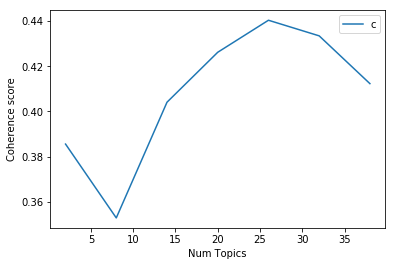

In [21]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3856
Num Topics = 8  has Coherence Value of 0.353
Num Topics = 14  has Coherence Value of 0.4041
Num Topics = 20  has Coherence Value of 0.4261
Num Topics = 26  has Coherence Value of 0.4403
Num Topics = 32  has Coherence Value of 0.4334
Num Topics = 38  has Coherence Value of 0.4123


In [ ]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
#Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=file_names)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'File_Names']

# Show
df_dominant_topic.head(10)

#save dominant topics to excel file
writer = ExcelWriter('dominant_topic.xlsx')
df_dominant_topic.to_excel(writer,'dominant_topic',index=False)
writer.save()

In [ ]:
#Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "File_Names"]

# Show
sent_topics_sorted.head()

#save representative documents to excel file
writer = ExcelWriter('representative_document.xlsx')
sent_topics_sorted.to_excel(writer,'representative_document',index=False)
writer.save()